In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
device

'cpu'

In [3]:
data = pd.read_csv('data_daily.csv')
data

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289
...,...,...
360,2021-12-27,10350408
361,2021-12-28,10219445
362,2021-12-29,10313337
363,2021-12-30,10310644


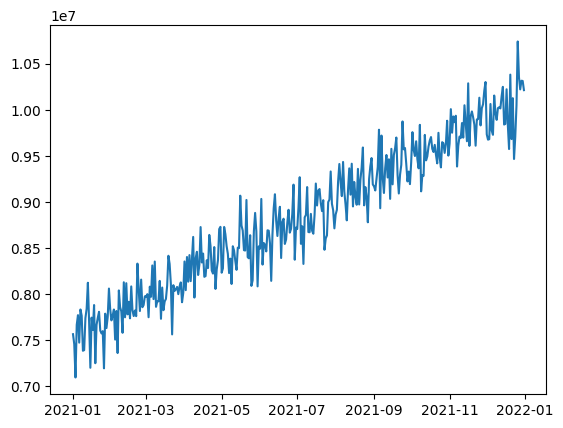

In [4]:
data['# Date'] = pd.to_datetime(data['# Date'])

plt.plot(data['# Date'],data['Receipt_Count'])

In [5]:
from copy import deepcopy

df = deepcopy(data)

df.set_index('# Date', inplace=True)

# add days from start to test correlation between time and receipt count
df['Days_From_Start'] = range(1, len(df) + 1)

# add day of week to test correlation between time and the day of the week
dow_range = list(range(0, len(df)))

for i in range(1,len(dow_range)):
    dow_range[i] = dow_range[i]%7

df['Day_of_Week'] = dow_range

df

,Receipt_Count,Days_From_Start,Day_of_Week
# Date,,,
2021-01-01,7564766,1,0
2021-01-02,7455524,2,1
2021-01-03,7095414,3,2
2021-01-04,7666163,4,3
2021-01-05,7771289,5,4
...,...,...,...
2021-12-27,10350408,361,3
2021-12-28,10219445,362,4
2021-12-29,10313337,363,5


In [6]:
# check corrollation of variables with receipt count
df.corr()['Receipt_Count']

Receipt_Count      1.000000
Days_From_Start    0.960658
Day_of_Week        0.002660
Name: Receipt_Count, dtype: float64

In [7]:
df = deepcopy(data)

df.set_index('# Date', inplace=True)

np_df = df.to_numpy()

# create input values, time standardized for linear regression alg
X = np.arange(1,len(np_df)+1)
X_mean = X.mean()
X_std = X.std()
X = (X-X_mean)/X_std

# create target values, receipt count, also standardized
mean_count = np_df.mean()
std_count = np_df.std()
scaled_df = (np_df-mean_count)/std_count
y = deepcopy(scaled_df[:,0])

In [8]:
# seperate data, 80% training, 20% test
train_index = int(len(X) * 0.80)

X_train = X[:train_index]
X_test = X[train_index:]

y_train = y[:train_index]
y_test = y[train_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((292,), (73,), (292,), (73,))

In [9]:
# convert to torch tensor and ensures correct shape for model
X_train = torch.unsqueeze( torch.tensor(X_train).float(), 1)
y_train = torch.unsqueeze( torch.tensor(y_train).float(), 1)
X_test = torch.unsqueeze( torch.tensor(X_test).float(), 1)
y_test = torch.unsqueeze( torch.tensor(y_test).float(), 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([292, 1]),
 torch.Size([73, 1]),
 torch.Size([292, 1]),
 torch.Size([73, 1]))

In [10]:
# standard linear regression model class for pytorch on 1 dimensional input data
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [11]:
learningRate = 0.1 
epochs = 50

model = linearRegression(1, 1)
model.to(device)

linearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [12]:
# select Mean Squared Error loss and Stochastic Gradient Descent optimization rule
# both are standard for linear regression on 1 dimensional input
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [13]:
for epoch in range(epochs):
    inputs = X_train.to(device)
    labels = y_train.to(device)
    
    optimizer.zero_grad() 

    outputs = model(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()
    
    print('epoch: {}   MSE_loss: {}'.format(epoch, loss.item()))

epoch: 0   MSE_loss: 0.5667113661766052
epoch: 1   MSE_loss: 0.4520021677017212
epoch: 2   MSE_loss: 0.36801856756210327
epoch: 3   MSE_loss: 0.30511757731437683
epoch: 4   MSE_loss: 0.2571312189102173
epoch: 5   MSE_loss: 0.21999257802963257
epoch: 6   MSE_loss: 0.19093391299247742
epoch: 7   MSE_loss: 0.16801242530345917
epoch: 8   MSE_loss: 0.14982466399669647
epoch: 9   MSE_loss: 0.13533127307891846
epoch: 10   MSE_loss: 0.12374663352966309
epoch: 11   MSE_loss: 0.1144668385386467
epoch: 12   MSE_loss: 0.10702193528413773
epoch: 13   MSE_loss: 0.10104265809059143
epoch: 14   MSE_loss: 0.09623681008815765
epoch: 15   MSE_loss: 0.09237205237150192
epoch: 16   MSE_loss: 0.08926292508840561
epoch: 17   MSE_loss: 0.08676102757453918
epoch: 18   MSE_loss: 0.08474741131067276
epoch: 19   MSE_loss: 0.08312656730413437
epoch: 20   MSE_loss: 0.0818217545747757
epoch: 21   MSE_loss: 0.08077128231525421
epoch: 22   MSE_loss: 0.07992556691169739
epoch: 23   MSE_loss: 0.07924464344978333
epoch: 

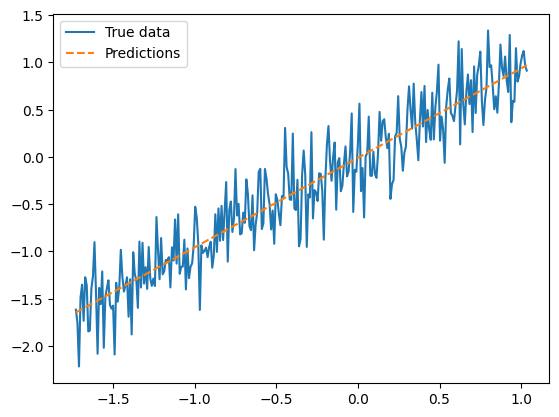

In [14]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').data.numpy()

plt.plot(X_train, y_train, label='True data')
plt.plot(X_train, predicted, '--', label='Predictions')
plt.legend()
plt.show()

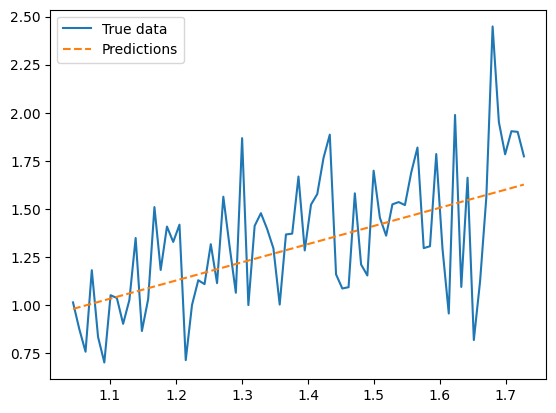

In [15]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').data.numpy()

plt.plot(X_test, y_test, label='True data')
plt.plot(X_test, predicted, '--', label='Predictions')
plt.legend()
plt.show()

In [16]:
torch.save(model.state_dict(), 'regression_model.pth')